# GloBI Part II: 

To explore using the GloBI database a bit further I decided to create some Python functions that make it easier for users to explore their favorite organism interactions.  This post will be very useful if you are interested in visualizing how organism interact with each other. One of the most efficient ways to view information like this is to use network graphs. Network graphs use information from both the link and node data sets to generate a graphical depiction of the network [1](http://support.sas.com/documentation/cdl/en/grnvwug/62918/HTML/default/viewer.htm#p0q343kxjyj36jn1e2z6lulkda3j.htm). See below for a very simple network graph.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5b/6n-graf.svg/1920px-6n-graf.svg.png)

So, in this post I will:

1. search for data by taxa name,
2. find the top target taxa for which our candidate organisms interact with,
3. use Python functions to create tools that automate the finding of top interaction taxa and connect to information about taxa on Wikipedia, and
4. create network visualizations using [networkx](https://networkx.github.io/)

In [37]:
import pandas as pd
import pytaxize
import re
import matplotlib.pyplot as plt

### Import interaction data

We are going to skip ahead to loading the data, if you would like to know more about accessing GloBI's data and learning a bit more about what the data is, please see the [previous post](http://curiositydata.org/part1_globi_access/).

If you would like to follow along on a Jupyter notebook, please download the notebook here: [part2_globi_exploration.ipynb](https://github.com/cabinetofcuriosity/globi_explore/blob/master/notebook/part2_globi_exploration.ipynb). To fully reproduce this analysis you will need the data file, which is 6.54GB. Download the `interactions.tsv` file here: [interactions.tsv.gz](https://depot.globalbioticinteractions.org/snapshot/target/data/tsv/interactions.tsv.gz).

In [38]:
# This takes a few minutes to load in.
data = pd.read_csv('../../interactions.tsv', delimiter='\t', encoding='utf-8')
len(data)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (21,22,23,24,25,26,27,28,29,30,41,42,43,44,45,46,47,48,49,50,55,58,59,60,61,62,63,64,65,68,69,72,73,78) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3729065

In [39]:
data.head()

,sourceTaxonId,sourceTaxonIds,sourceTaxonName,sourceTaxonRank,sourceTaxonPathNames,sourceTaxonPathIds,sourceTaxonPathRankNames,sourceTaxonSpeciesName,sourceTaxonSpeciesId,sourceTaxonGenusName,...,eventDateUnixEpoch,argumentTypeId,referenceCitation,referenceDoi,referenceUrl,sourceCitation,sourceNamespace,sourceArchiveURI,sourceDOI,sourceLastSeenAtUnixEpoch
0,EOL_V2:1056176,EOL_V2:1056176 | WORMS:137208 | WD:Q301089 | O...,Lepidochelys kempii,species,Cheloniidae | Lepidochelys | Lepidochelys kempii,EOL:8123 | EOL:59582 | EOL_V2:1056176,family | genus | species,Lepidochelys kempii,EOL_V2:1056176,Lepidochelys,...,7.574076e+11,https://en.wiktionary.org/wiki/support,Donna Shaver. 1998. Sea Turtle Strandings Alon...,NaN,NaN,http://gomexsi.tamucc.edu,GoMexSI/interaction-data,https://github.com/GoMexSI/interaction-data/ar...,NaN,2019-02-12T23:05:38.038Z
1,EOL_V2:1056176,EOL_V2:1056176 | WORMS:137208 | WD:Q301089 | O...,Lepidochelys kempii,species,Cheloniidae | Lepidochelys | Lepidochelys kempii,EOL:8123 | EOL:59582 | EOL_V2:1056176,family | genus | species,Lepidochelys kempii,EOL_V2:1056176,Lepidochelys,...,7.574076e+11,https://en.wiktionary.org/wiki/support,Donna Shaver. 1998. Sea Turtle Strandings Alon...,NaN,NaN,http://gomexsi.tamucc.edu,GoMexSI/interaction-data,https://github.com/GoMexSI/interaction-data/ar...,NaN,2019-02-12T23:05:38.038Z
2,EOL_V2:1056176,EOL_V2:1056176 | WORMS:137208 | WD:Q301089 | O...,Lepidochelys kempii,species,Cheloniidae | Lepidochelys | Lepidochelys kempii,EOL:8123 | EOL:59582 | EOL_V2:1056176,family | genus | species,Lepidochelys kempii,EOL_V2:1056176,Lepidochelys,...,7.574076e+11,https://en.wiktionary.org/wiki/support,Donna Shaver. 1998. Sea Turtle Strandings Alon...,NaN,NaN,http://gomexsi.tamucc.edu,GoMexSI/interaction-data,https://github.com/GoMexSI/interaction-data/ar...,NaN,2019-02-12T23:05:38.038Z
3,EOL_V2:1056176,EOL_V2:1056176 | WORMS:137208 | WD:Q301089 | O...,Lepidochelys kempii,species,Cheloniidae | Lepidochelys | Lepidochelys kempii,EOL:8123 | EOL:59582 | EOL_V2:1056176,family | genus | species,Lepidochelys kempii,EOL_V2:1056176,Lepidochelys,...,7.574076e+11,https://en.wiktionary.org/wiki/support,Donna Shaver. 1998. Sea Turtle Strandings Alon...,NaN,NaN,http://gomexsi.tamucc.edu,GoMexSI/interaction-data,https://github.com/GoMexSI/interaction-data/ar...,NaN,2019-02-12T23:05:38.038Z
4,EOL_V2:1056176,EOL_V2:1056176 | WORMS:137208 | WD:Q301089 | O...,Lepidochelys kempii,species,Cheloniidae | Lepidochelys | Lepidochelys kempii,EOL:8123 | EOL:59582 | EOL_V2:1056176,family | genus | species,Lepidochelys kempii,EOL_V2:1056176,Lepidochelys,...,7.574076e+11,https://en.wiktionary.org/wiki/support,Donna Shaver. 1998. Sea Turtle Strandings Alon...,NaN,NaN,http://gomexsi.tamucc.edu,GoMexSI/interaction-data,https://github.com/GoMexSI/interaction-data/ar...,NaN,2019-02-12T23:05:38.038Z


In [40]:
# Checking out all the interaction types
data['interactionTypeName'].unique()

array(['eats', 'interactsWith', 'pollinates', 'parasiteOf', 'preysOn',
       'pathogenOf', 'visitsFlowersOf', 'dispersalVectorOf', 'adjacentTo',
       'endoparasitoidOf', 'symbiontOf', 'endoparasiteOf', 'hasVector',
       'ectoParasiteOf', 'vectorOf', 'livesOn', 'livesNear',
       'parasitoidOf', 'guestOf', 'livesInsideOf', 'farms',
       'ectoParasitoid', 'inhabits', 'kills', 'hasDispersalVector',
       'livesUnder', 'kleptoparasiteOf', 'hasHost', 'eatenBy',
       'flowersVisitedBy', 'hasParasite', 'preyedUponBy', 'pollinatedBy',
       'hostOf', 'visits', 'commensalistOf', 'hasPathogen'], dtype=object)

#### Drop duplicates

My goal is to look at the different types of interaction data in the dataset and build network visualizations from this information, therefore I am only really interested in unique cases of interaction. So in this next step let's drop the data that isn't unique in these three columns. 

In [41]:
data.drop_duplicates(['sourceTaxonId', 'interactionTypeName', 'targetTaxonId'], inplace = True)

In [42]:
## We dropped from 
len(data)

967624

### Searching a particular taxa

![human]("../img/biodiversitylibrary.org/page/33606717.jpg")

For example, suppose we are interested in the interactions involving 'Homo sapiens'.

In [43]:
# What are all the types of interactions involving Homo sapiens as sourceTaxon?
data[data['sourceTaxonName'] == 'Homo sapiens']['interactionTypeName'].unique()

array(['interactsWith', 'eats', 'hostOf'], dtype=object)

In [44]:
# Number of records of interactions involving Homo sapiens as sourceTaxon?
len(data[data['sourceTaxonName'] == 'Homo sapiens'])

666

Now let's focus on a certain type of interaction involving the sourceTaxon "Homo sapiens", for example, "eats".

In [45]:
hs_eats_data = data[(data['sourceTaxonName'] == 'Homo sapiens') & (data['interactionTypeName'] == 'eats')]

In [46]:
hs_eats_data.head()

,sourceTaxonId,sourceTaxonIds,sourceTaxonName,sourceTaxonRank,sourceTaxonPathNames,sourceTaxonPathIds,sourceTaxonPathRankNames,sourceTaxonSpeciesName,sourceTaxonSpeciesId,sourceTaxonGenusName,...,eventDateUnixEpoch,argumentTypeId,referenceCitation,referenceDoi,referenceUrl,sourceCitation,sourceNamespace,sourceArchiveURI,sourceDOI,sourceLastSeenAtUnixEpoch
525804,EOL:327955,EOL:327955 | INAT_TAXON:43584 | NBN:NHMSYS0000...,Homo sapiens,species,Animalia | Chordata | Mammalia | Primates | Ho...,EOL:1 | EOL:694 | EOL:1642 | EOL:1645 | EOL:16...,kingdom | phylum | class | order | family | ge...,Homo sapiens,EOL:327955,Homo,...,NaN,https://en.wiktionary.org/wiki/support,"Worthington, A. 1989. Adaptations for avian fr...",10.1007/BF00379040.,NaN,F. Gabriel. Muñoz. 2017. Palm-Animal frugivore...,fgabriel1891/Plant-Frugivore-Interactions-Sout...,https://github.com/fgabriel1891/Plant-Frugivor...,NaN,2019-02-12T23:08:35.599Z
527097,EOL:327955,EOL:327955 | INAT_TAXON:43584 | NBN:NHMSYS0000...,Homo sapiens,species,Animalia | Chordata | Mammalia | Primates | Ho...,EOL:1 | EOL:694 | EOL:1642 | EOL:1645 | EOL:16...,kingdom | phylum | class | order | family | ge...,Homo sapiens,EOL:327955,Homo,...,NaN,https://en.wiktionary.org/wiki/support,"Hazarika, T.k. Lalramchuana. Nautiyal. B.P. 20...",10.1007/s10722-012-9799-5,NaN,F. Gabriel. Muñoz. 2017. Palm-Animal frugivore...,fgabriel1891/Plant-Frugivore-Interactions-Sout...,https://github.com/fgabriel1891/Plant-Frugivor...,NaN,2019-02-12T23:08:35.599Z
527098,EOL:327955,EOL:327955 | INAT_TAXON:43584 | NBN:NHMSYS0000...,Homo sapiens,species,Animalia | Chordata | Mammalia | Primates | Ho...,EOL:1 | EOL:694 | EOL:1642 | EOL:1645 | EOL:16...,kingdom | phylum | class | order | family | ge...,Homo sapiens,EOL:327955,Homo,...,NaN,https://en.wiktionary.org/wiki/support,"Hazarika, T.k. Lalramchuana. Nautiyal. B.P. 20...",10.1007/s10722-012-9799-5,NaN,F. Gabriel. Muñoz. 2017. Palm-Animal frugivore...,fgabriel1891/Plant-Frugivore-Interactions-Sout...,https://github.com/fgabriel1891/Plant-Frugivor...,NaN,2019-02-12T23:08:35.599Z
527099,EOL:327955,EOL:327955 | INAT_TAXON:43584 | NBN:NHMSYS0000...,Homo sapiens,species,Animalia | Chordata | Mammalia | Primates | Ho...,EOL:1 | EOL:694 | EOL:1642 | EOL:1645 | EOL:16...,kingdom | phylum | class | order | family | ge...,Homo sapiens,EOL:327955,Homo,...,NaN,https://en.wiktionary.org/wiki/support,"Hazarika, T.k. Lalramchuana. Nautiyal. B.P. 20...",10.1007/s10722-012-9799-5,NaN,F. Gabriel. Muñoz. 2017. Palm-Animal frugivore...,fgabriel1891/Plant-Frugivore-Interactions-Sout...,https://github.com/fgabriel1891/Plant-Frugivor...,NaN,2019-02-12T23:08:35.599Z
527100,EOL:327955,EOL:327955 | INAT_TAXON:43584 | NBN:NHMSYS0000...,Homo sapiens,species,Animalia | Chordata | Mammalia | Primates | Ho...,EOL:1 | EOL:694 | EOL:1642 | EOL:1645 | EOL:16...,kingdom | phylum | class | order | family | ge...,Homo sapiens,EOL:327955,Homo,...,NaN,https://en.wiktionary.org/wiki/support,"Hazarika, T.k. Lalramchuana. Nautiyal. B.P. 20...",10.1007/s10722-012-9799-5,NaN,F. Gabriel. Muñoz. 2017. Palm-Animal frugivore...,fgabriel1891/Plant-Frugivore-Interactions-Sout...,https://github.com/fgabriel1891/Plant-Frugivor...,NaN,2019-02-12T23:08:35.599Z


In [47]:
len(hs_eats_data)

378

I'm going to clean up this table a bit.  The code below is first selecting which columns I want to keep and droping data with missing values from 'targetTaxonId','targetTaxonName','targetTaxonPathNames','targetTaxonPathIds'.

In [48]:
target_hs_eats = hs_eats_data[['targetTaxonId',
       'targetTaxonName','targetTaxonPathNames',
       'targetTaxonPathIds', 'targetTaxonPathRankNames',
       'targetTaxonSpeciesName', 'targetTaxonSpeciesId',
       'targetTaxonGenusName', 'targetTaxonGenusId', 'targetTaxonFamilyName',
       'targetTaxonFamilyId', 'targetTaxonOrderName', 'targetTaxonOrderId',
       'targetTaxonClassName', 'targetTaxonClassId', 'targetTaxonPhylumName',
       'targetTaxonPhylumId', 'targetTaxonKingdomName', 'targetTaxonKingdomId']].dropna(subset=['targetTaxonId',
       'targetTaxonName','targetTaxonPathNames','targetTaxonPathIds'])
target_hs_eats.head()

,targetTaxonId,targetTaxonName,targetTaxonPathNames,targetTaxonPathIds,targetTaxonPathRankNames,targetTaxonSpeciesName,targetTaxonSpeciesId,targetTaxonGenusName,targetTaxonGenusId,targetTaxonFamilyName,targetTaxonFamilyId,targetTaxonOrderName,targetTaxonOrderId,targetTaxonClassName,targetTaxonClassId,targetTaxonPhylumName,targetTaxonPhylumId,targetTaxonKingdomName,targetTaxonKingdomId
525804,EOL_V2:1142757,Hyphaene petersiana,Plantae | Tracheophyta | Liliopsida | Arecales...,EOL_V2:281 | EOL:4077 | EOL_V2:4074 | EOL:8192...,kingdom | phylum | class | order | family | ge...,Hyphaene petersiana,EOL_V2:1142757,Hyphaene,EOL:29186,Arecaceae,EOL:8193,Arecales,EOL:8192,Liliopsida,EOL_V2:4074,Tracheophyta,EOL:4077,Plantae,EOL_V2:281
527098,EOL:2508660,Syzygium cumini,Plantae | Tracheophyta | Magnoliopsida | Myrta...,EOL_V2:281 | EOL:4077 | EOL:283 | EOL:4328 | E...,kingdom | phylum | class | order | family | ge...,Syzygium cumini,EOL:2508660,Syzygium,EOL_V2:2508658,Myrtaceae,EOL:8095,Myrtales,EOL:4328,Magnoliopsida,EOL:283,Tracheophyta,EOL:4077,Plantae,EOL_V2:281
527099,EOL:4263,Styracaceae,Plantae | Tracheophyta | Magnoliopsida | Erica...,EOL_V2:281 | EOL:4077 | EOL:283 | EOL:4186 | E...,kingdom | phylum | class | order | family,NaN,NaN,NaN,NaN,Styracaceae,EOL:4263,Ericales,EOL:4186,Magnoliopsida,EOL:283,Tracheophyta,EOL:4077,Plantae,EOL_V2:281
527100,EOL_V2:2888768,Spondias pinnata,Plantae | Tracheophyta | Magnoliopsida | Sapin...,EOL_V2:281 | EOL:4077 | EOL:283 | EOL:4311 | E...,kingdom | phylum | class | order | family | ge...,Spondias pinnata,EOL_V2:2888768,Spondias,EOL:61097,Anacardiaceae,EOL:4410,Sapindales,EOL:4311,Magnoliopsida,EOL:283,Tracheophyta,EOL:4077,Plantae,EOL_V2:281
527101,EOL:1082661,Smilax ovalifolia,Plantae | Tracheophyta | Liliopsida | Liliales...,EOL_V2:281 | EOL:4077 | EOL_V2:4074 | EOL:4173...,kingdom | phylum | class | order | family | ge...,Smilax ovalifolia,EOL:1082661,Smilax,EOL_V2:107257,Smilacaceae,EOL:8171,Liliales,EOL:4173,Liliopsida,EOL_V2:4074,Tracheophyta,EOL:4077,Plantae,EOL_V2:281


In [49]:
len(target_hs_eats)

309

To get a brief overview of what type of data we have for Homo sapiens, we look at all the taxa that are associated with humans' eating habits.

In [50]:
target_hs_eats.groupby(target_hs_eats['targetTaxonClassName']).size().sort_values(ascending = False)

targetTaxonClassName
Mammalia           102
Actinopterygii      53
Magnoliopsida       52
Aves                25
Bivalvia            19
Liliopsida           8
Malacostraca         7
Gastropoda           5
Elasmobranchii       4
Reptilia             4
Ascidiacea           3
Insecta              3
Anthozoa             2
Holothuroidea        2
Cephalopoda          2
Anopla               1
Bangiophyceae        1
Ulvophyceae          1
Chondrichthyes       1
Chrysophyceae        1
Dothideomycetes      1
Teleostei            1
Phaeophyceae         1
Echinoidea           1
dtype: int64

Above all, we have found a list of top target classes of 'Homo sapiens' for the "eats" interaction type. But what if I wanted to look for the top target, not only in "eats", but across any of the columns. For this I created a function, 'find_top_target', that could get a list of any rank for any source taxon and any interaction type. 

In [51]:
def find_top_target(source, interaction_type, rank):
    """ Function that takes inputs of interests and finds corresponding top targets.
    Args:
        source: the source taxon that we are interested in, can be in any level.
        interaction_type: the interaction type that we are interested in, 
                          should be consistent with the names of interaction types from tsv.file.
        rank: the level of target taxon that we are interested in, 
              should be consistent with the column names of tsv.file, such as 'targetTaxonFamilyName', 'targetTaxonOrderName', 
              'targetTaxonClassName'...
    Returns:
        The top target taxons in certain rank for certain source taxon and certain interaction type, 
        in descending order of number of records.
    """
    d = data[data['sourceTaxonName'] == source]
    interacts_d = d[d['interactionTypeName'] == interaction_type]
    interacts_d_cleaned = interacts_d[['targetTaxonId',
       'targetTaxonName','targetTaxonPathNames',
       'targetTaxonPathIds', 'targetTaxonPathRankNames',
       'targetTaxonSpeciesName', 'targetTaxonSpeciesId',
       'targetTaxonGenusName', 'targetTaxonGenusId', 'targetTaxonFamilyName',
       'targetTaxonFamilyId', 'targetTaxonOrderName', 'targetTaxonOrderId',
       'targetTaxonClassName', 'targetTaxonClassId', 'targetTaxonPhylumName',
       'targetTaxonPhylumId', 'targetTaxonKingdomName', 'targetTaxonKingdomId']].dropna(subset=['targetTaxonId',
       'targetTaxonName','targetTaxonPathNames','targetTaxonPathIds'])
    return interacts_d_cleaned.groupby(interacts_d_cleaned[rank]).size().sort_values(ascending = False)

Here are a few examples of the function at work.

In [52]:
# Find top target taxons in Class for homo sapiens with interaction type 'eats'
find_top_target('Homo sapiens', 'interactsWith', 'targetTaxonClassName')

targetTaxonClassName
Mammalia           109
Actinopterygii      42
Insecta             20
Arachnida           12
Aves                12
Magnoliopsida        8
Liliopsida           8
Eurotiomycetes       7
Reptilia             4
Bivalvia             4
Cestoda              4
Elasmobranchii       3
Malacostraca         3
Tremellomycetes      2
Dothideomycetes      2
Cephalopoda          2
Agaricomycetes       2
Gastropoda           1
Echinoidea           1
Conoidasida          1
Coccidia             1
Chondrichthyes       1
Incertae             1
Polyplacophora       1
Secernentea          1
Zoomastigophora      1
dtype: int64

In [53]:
#Find top target taxons in Family for homo sapiens with interaction type 'hostOf'
find_top_target('Homo sapiens', 'hostOf', 'targetTaxonFamilyName')

targetTaxonFamilyName
Ixodidae              11
Diphyllobothriidae     4
Rhopalopsyllidae       3
Pulicidae              3
Trombiculidae          1
Taeniidae              1
Pediculidae            1
Oxyuridae              1
Echinorhynchidae       1
dtype: int64

Instead of inputting a source species, what if we input a source in other levels like class or family?

In [54]:
# Find top target taxons in Class for Actinopterygii with interaction type 'preysOn'
find_top_target('Actinopterygii', 'preysOn', 'targetTaxonClassName')

targetTaxonClassName
Actinopterygii    7
Cephalopoda       1
dtype: int64

Here, the source 'Actinopterygii' itself is in the class level. And we can see that the top target class of 'Actinopterygii' preys on is also 'Actinopterygii', which means the species under 'Actinopterygii' always preys on species under same the same class. But what is Actinopterygii? 

### Link our results with Wikipedia pages

If you are like me you have been copying and pasting these species and taxon names and Googling them to find out what the hell they are.  I learned that Actinopterygii is fish, which makes sense, especially because the lead contributor to GloBI is Fishbase which might skew these results a bit. Also, if you are like me, you have gotten sick of all the copying and pasting, so I created a tool that did that for me. The function below allows us to link the results of my top targets with their associated Wikipedia pages:  

In [55]:
def make_clickable_both(val): 
    name, url = val.split('#')
    return f'<a href="{url}">{name}</a>'

In [56]:
def top_targets_with_wiki(source, interaction_type, rank):
    """ Function that takes inputs of interests and finds corresponding top targets linked to their Wikipedia pages.
    Args:
        source: the source taxon that we are interested in, can be in any level.
        interaction_type: the interaction type that we are interested in, 
                          should be consistent with the names of interaction types from tsv.file.
        rank: the level of target taxon that we are interested in, 
              should be consistent with the column names of tsv.file, such as 'targetTaxonFamilyName', 'targetTaxonOrderName', 
              'targetTaxonClassName'...
    Returns:
        The top target taxons in certain rank with clickable Wikipedia links for certain source taxon and certain interaction type, 
        in descending order of number of records.
    """
    top_targets = find_top_target(source, interaction_type, rank)
    target_df = pd.DataFrame(top_targets)
    target_df.columns = ['count']

    urls = dict(name= list(target_df.index), 
    url= ['https://en.wikipedia.org/wiki/' + str(i) for i in list(target_df.index)])
    target_df.index = [i + '#' + j for i,j in zip(urls['name'], urls['url'])]
    index_list = list(target_df.index)
    target_df.index =[make_clickable_both(i) for i in index_list]
    df = target_df.style.format({'wiki': make_clickable_both})
    
    return df

![fish](../img/biodiversitylibrary.org/page/32012466.jpg)

### Examples of top_targets_with_links

In [57]:
top_targets_with_wiki('Carollia perspicillata', 'eats', 'targetTaxonClassName')

,count
Magnoliopsida,40
Liliopsida,3


In [58]:
top_targets_with_wiki('Homo sapiens', 'hostOf', 'targetTaxonFamilyName')

,count
Ixodidae,11
Diphyllobothriidae,4
Rhopalopsyllidae,3
Pulicidae,3
Trombiculidae,1
Taeniidae,1
Pediculidae,1
Oxyuridae,1
Echinorhynchidae,1


In [59]:
top_targets_with_wiki('Actinopterygii', 'preysOn', 'targetTaxonClassName')

,count
Actinopterygii,7
Cephalopoda,1


### Making directed graphs

The most obvious way to look at this type of data is through network visualizations. For this I used the [networkx](https://networkx.github.io/) Python package. Althought there are many different ways in which you can visualize networks, I found this package the easiest to work with. 

First I created a function that plots the results from the `find_top_target` function I created earlier. This `plot_interaction` function inputs the same arguments with one additional argument to allow specifying how many you would like to include in the network.

In [60]:
import networkx as nx

In [61]:
def plot_interaction(source, interaction_type, rank, n = None):
    """ Function that plots directed graphs of results from 'find_top_target'.
    Args:
        source: the source taxon that we are interested in, can be in any level.
        interaction_type: one interaction type or a list of interaction types that we are interested in, 
                          should be consistent with the names of interaction types from tsv.file.
        rank: the level of target taxon that we are interested in, 
              should be consistent with the column names of tsv.file, such as 'targetTaxonFamilyName', 'targetTaxonOrderName', 
              'targetTaxonClassName'...
        n: select first n top targets to plot, default to plot all top targets.
    Returns:
        A directed graph containing information of the source and target taxons, interaction_type
    """
    G = nx.DiGraph()
    
    if not isinstance(interaction_type, list): 
        interaction_type = [interaction_type]
    
    for interaction in interaction_type:
        if n:
            top_targets = find_top_target(source, interaction, rank)[: n]
        else:
            top_targets = find_top_target(source, interaction, rank)

        for name in ([source]+ list(top_targets.index)):
            G.add_node(name)

        for target in top_targets.index:
            G.add_edge(source, target, label = interaction)

    
    plt.figure(figsize=(8,8))
    edge_labels = nx.get_edge_attributes(G,'label')

    pos = nx.spring_layout(G) 
    nx.draw_networkx_edge_labels(G,pos, edge_labels = edge_labels, font_size=15, font_color='orange')

    nx.draw_networkx(G, pos, with_labels=True, node_size=1500, node_color="skyblue", alpha= 1, arrows=True, 
                    linewidths=1, font_color="grey", font_size=15, style = 'dashed')

    plt.axis('off')
    plt.tight_layout()
    plt.show()

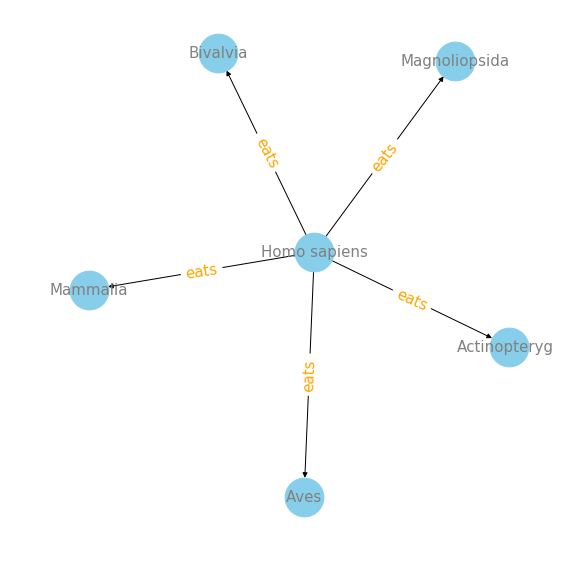

In [62]:
#interaction plot of top 5 target classes that Homo sapiens eats:
plot_interaction('Homo sapiens', 'eats', 'targetTaxonClassName', 5)

We can see that Mammalia, Magnoliopsida, Actinopterygii, Aves and Bivalvia are top 5 target class that Homo sapiens eats. For me, it is surprising to see Magnoliopsida, which is a valid botanical name for a class of flowering plants.

![magnolia](biodiversitylibrary.org/page/620690.jpg)

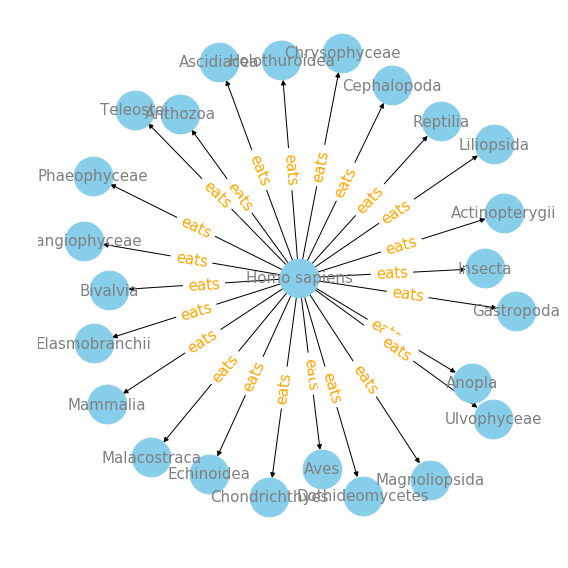

In [63]:
#without indicating n, interaction plot of all target classes that Homo sapiens eats:
plot_interaction('Homo sapiens', 'eats', 'targetTaxonClassName')

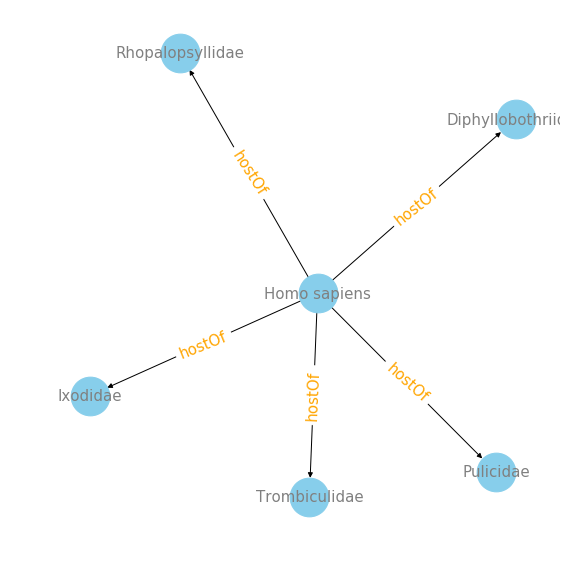

In [64]:
#interaction plot of top 5 families that Homo sapiens are host of :
plot_interaction('Homo sapiens', 'hostOf', 'targetTaxonFamilyName', 5)

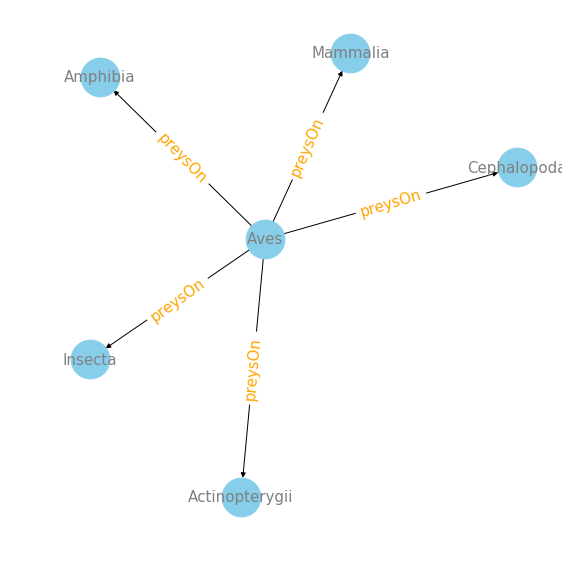

In [75]:
#interaction plot of top 5 classes that Aves (birds!) preys on :
plot_interaction('Aves', 'preysOn', 'targetTaxonClassName', 5)

It's really fun to see what birds prey on! They have a wide range of groups of species that they prey on! Insects, mammals, fish, amphibians, and cephlapods. Feel free to use this function to explore more species within this data. I hope this makes it easier for other to explore this amazing data.

Below are examples of ways to map more than one interaction type. The first example shows all the top five families in which Humans are a host of, then below is the top five families of species with both the 'host of' and 'eats' interation types

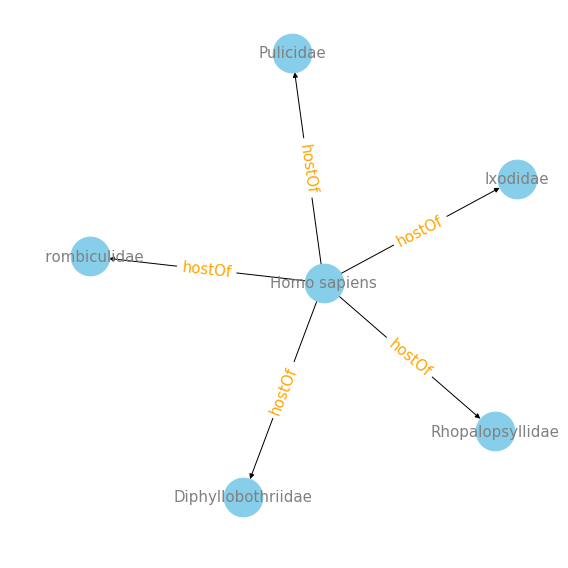

In [78]:
#interaction plot of top 5 families that Homo sapiens eats and top 5 families that Homo sapiens are host of :
plot_interaction('Homo sapiens', ['hostOf'], 'targetTaxonFamilyName', 5)

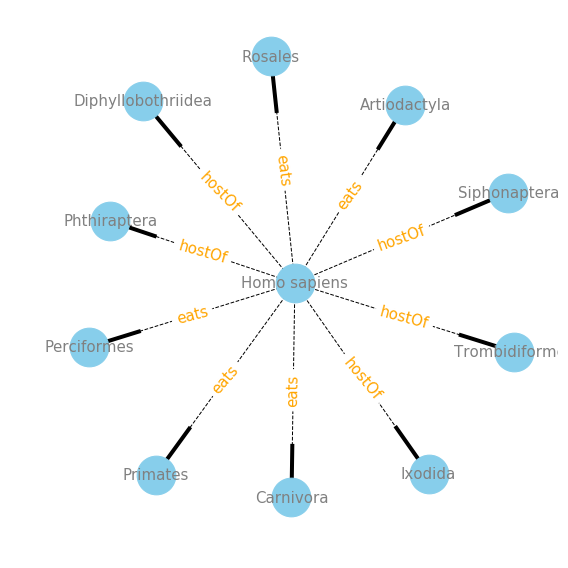

In [47]:
#interaction plot of top 5 orders that Homo sapiens eats and top 5 orders that Homo sapiens are host of :
plot_interaction('Homo sapiens', ['eats', 'hostOf'], 'targetTaxonOrderName', 5)

### Conclusion: What I learned while working with GloBi